## Imports

In [1]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import matplotlib.colors as colors
import cartopy.crs as ccrs

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35501")
client

<Client: 'tcp://127.0.0.1:35501' processes=4 threads=4, memory=32.00 GiB>

2024-10-14 21:58:53,409 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## Open the data

In [4]:
# data in persistent bucket
target_url = 'gs://leap-persistent/tomnicholas/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding_3_hourly.zarr'

In [5]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [6]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.682792496

In [7]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [8]:
hist_ds['histogram_vort_strain_div'] = hist_ds['histogram_vort_strain_div'] / 80

In [9]:
## Pick a region and look at the shape

In [18]:

h = hist_ds['histogram_vort_strain_div']#.sel(region=slice(0,200))#.sel(region=230)
h['center_lat'] = hist_ds.vertices_latitude.mean('vertices')
h['center_lon'] = hist_ds.vertices_longitude.mean('vertices')
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
h['center_lon'] = h['center_lon'].where(max_vert<100,((hist_ds.vertices_longitude.where(max_vert>100).min('vertices') +hist_ds.vertices_longitude.where(max_vert>100).max('vertices')+360)/2))
h1 = h.mean('time')#.isel(strain_bin=10)
h1['theta'] = np.arctan2(h1['div_bin'],h1['vort_bin'])+np.pi
#h1['theta'] = (h1['theta'].where(h1['div_bin']<0, h1['theta']+np.pi)+np.pi/2)

bins = np.linspace(0, 2*np.pi, 20)
weights=h1.fillna(0)


#MUST FIX THIS SO WE ARE CONSISTENTLY PICKING VALUES WITH strain>f
h2 = histogram(h1['theta'], bins=bins,weights=weights, dim=['div_bin','vort_bin'])
cumstrain = (h1.mean(['div_bin','vort_bin']).cumsum('strain_bin')/h1.mean(['div_bin','vort_bin']).sum('strain_bin'))
loc_99 = cumstrain.where(cumstrain>0.99).idxmin('strain_bin')
loc_999 = cumstrain.where(cumstrain>0.9999).idxmin('strain_bin')


cumvort = (h1.mean(['div_bin','strain_bin']).cumsum('vort_bin')/h1.mean(['div_bin','strain_bin']).sum('vort_bin'))
locv_99 = cumvort.where(cumvort>0.99).idxmin('vort_bin')
locv_999 = cumvort.where(cumvort>0.9999).idxmin('vort_bin')

hr = h1.reindex(vort_bin=list(reversed(h1.vort_bin)))
cumvortn = (hr.mean(['div_bin','strain_bin']).cumsum('vort_bin')/hr.mean(['div_bin','strain_bin']).sum('vort_bin'))
locvn_99 = -(cumvortn.where(cumvortn>0.99).idxmin('vort_bin'))
locvn_999 = -(cumvortn.where(cumvortn>0.9999).idxmin('vort_bin'))

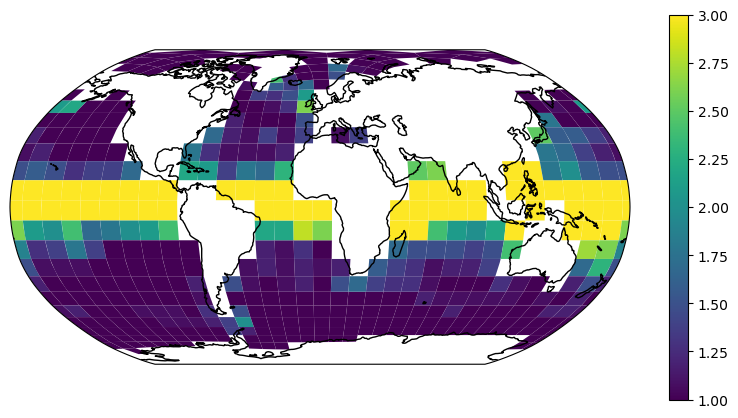

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=loc_99, cmap='viridis', edgecolors='none', transform=ccrs.PlateCarree())
#, norm=mpl.colors.LogNorm()
ax.add_collection(coll)
coll.set_clim(vmin=1, vmax=3)
ax.autoscale_view()
plt.colorbar(coll)
#plt.gcf().savefig('strain_99.png')

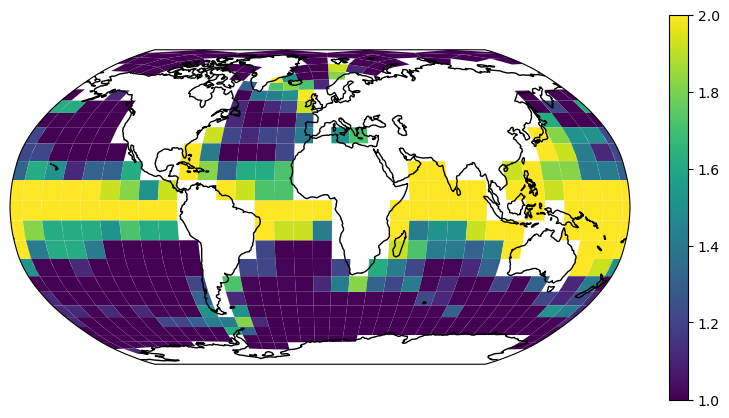

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
#norm = plt.Normalize(vmin=0, vmax=3)
coll = PolyCollection(verts, array=locv_99, cmap='viridis', edgecolors='none', transform=ccrs.PlateCarree())
ax.add_collection(coll)
coll.set_clim(vmin=1, vmax=2)
ax.autoscale_view()
plt.colorbar(coll)

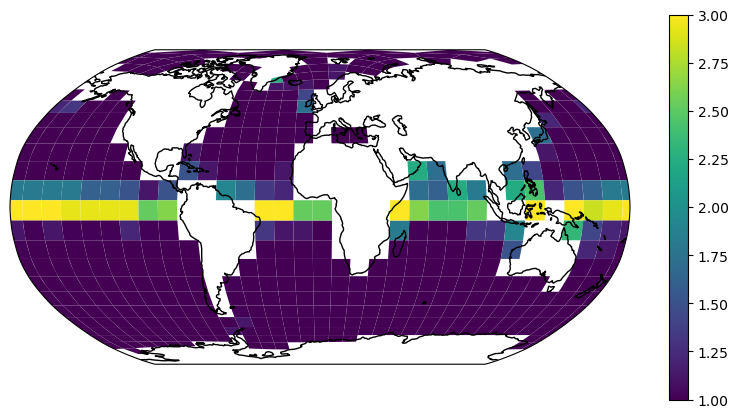

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
#norm = plt.Normalize(vmin=0, vmax=3)
coll = PolyCollection(verts, array=locvn_99, cmap='viridis', edgecolors='none', transform=ccrs.PlateCarree())
ax.add_collection(coll)
coll.set_clim(vmin=0, vmax=1)
ax.autoscale_view()
plt.colorbar(coll)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=locv_999, cmap='viridis', edgecolors='none', transform=ccrs.PlateCarree())
ax.add_collection(coll)
ax.autoscale_view()
plt.colorbar(coll)

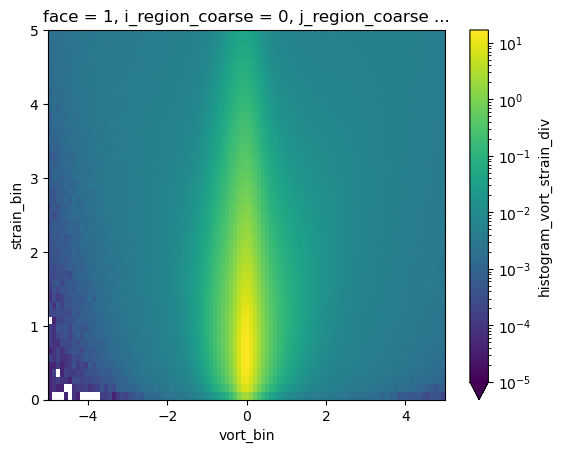

In [29]:
h.isel(region=30).mean('time').sum('div_bin').plot(x='vort_bin', norm=mpl.colors.LogNorm(), vmin=10**-5)

In [49]:
test1 = (h1.mean(['div_bin','vort_bin']).cumsum('strain_bin')/h1.mean(['div_bin','vort_bin']).sum('strain_bin'))
#test1['strain_bin'][test1.where(test1>0.99).argmin('strain_bin').values]
test1

<xarray.DataArray 'histogram_vort_strain_div' (region: 438, strain_bin: 49)> Size: 172kB
dask.array<truediv, shape=(438, 49), dtype=float64, chunksize=(1, 49), chunktype=numpy.ndarray>
Coordinates:
    face             (region) int64 4kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse  (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse  (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num       (region) int64 4kB 4 5 6 7 13 14 ... 791 792 793 798 799
  * strain_bin       (strain_bin) float64 392B 0.05102 0.1531 ... 4.847 4.949
    center_lat       (region) float32 2kB dask.array<chunksize=(438,), meta=np.ndarray>
    center_lon       (region) float32 2kB dask.array<chunksize=(438,), meta=np.ndarray>
Dimensions without coordinates: region

In [39]:
h1.mean(['div_bin','vort_bin']).isel(region=30).quantile(0.5, dim='strain_bin', keep_attrs=True)

<xarray.DataArray 'histogram_vort_strain_div' ()> Size: 8B
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 8B 0.5

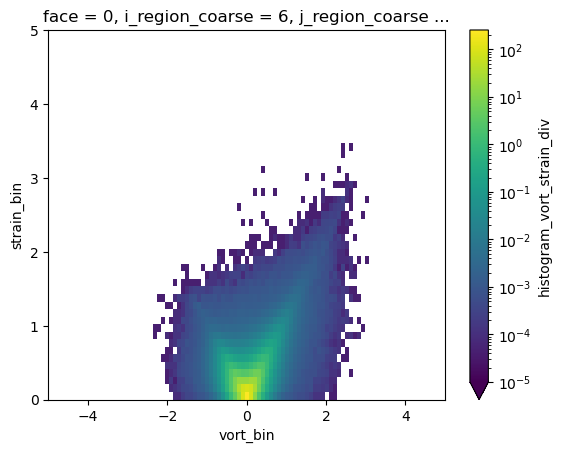

In [28]:
h.isel(region=20).mean('time').sum('div_bin').plot(x='vort_bin', norm=mpl.colors.LogNorm(), vmin=10**-5)

In [21]:
h1.mean(['div_bin','vort_bin']).strain_bin

<xarray.DataArray 'strain_bin' (strain_bin: 49)> Size: 392B
array([0.05102 , 0.153061, 0.255102, 0.357143, 0.459184, 0.561224, 0.663265,
       0.765306, 0.867347, 0.969388, 1.071429, 1.173469, 1.27551 , 1.377551,
       1.479592, 1.581633, 1.683673, 1.785714, 1.887755, 1.989796, 2.091837,
       2.193878, 2.295918, 2.397959, 2.5     , 2.602041, 2.704082, 2.806122,
       2.908163, 3.010204, 3.112245, 3.214286, 3.316327, 3.418367, 3.520408,
       3.622449, 3.72449 , 3.826531, 3.928571, 4.030612, 4.132653, 4.234694,
       4.336735, 4.438776, 4.540816, 4.642857, 4.744898, 4.846939, 4.94898 ])
Coordinates:
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949

In [19]:
def calc_f_coriolis(ds_grid):
    """Calculate the coriolis frequency for all latitudes"""
    
    lat = ds_grid['YC'].reset_coords(drop=True).rename('lat')
    
    rotation_rate = 7.2921e-5  # rad/s
    f_coriolis = (
        2 * rotation_rate * np.sin(lat*np.pi/180)
    ).rename('f_coriolis')
    
    return f_coriolis

<xarray.Dataset> Size: 62GB
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 4kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 296B 2011-09-17T22:30:00...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 62GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>
    lon                        (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>

In [ ]:
max1 = h_gt_f.argmax('theta_bin').load()

In [ ]:
#h2.isel(region=0).plot(norm=colors.LogNorm(), vmin=1e-2)

In [112]:
peakiness = ((h_gt_f.max('theta_bin')-h_gt_f.min('theta_bin'))/h_gt_f.min('theta_bin')).load()
#write_peakiness = peakiness.to_dataset()
#write_peakiness = write_peakiness.assign_coords({"center_lon": h['center_lon']})
#write_peakiness['center_lon']=h['center_lon']
#write_peakiness.to_netcdf('peakiness1.nc')

In [113]:
#write_peakiness
#read_peakiness = xr.open_dataset('peakiness1.nc')
import cartopy.crs as ccrs

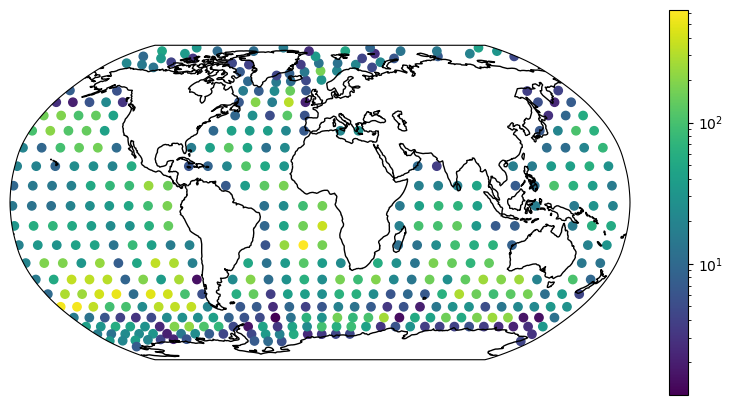

In [38]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()

cs = plt.scatter(x=h['center_lon'], y=h['center_lat'], c=peakiness, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
plt.colorbar(cs)

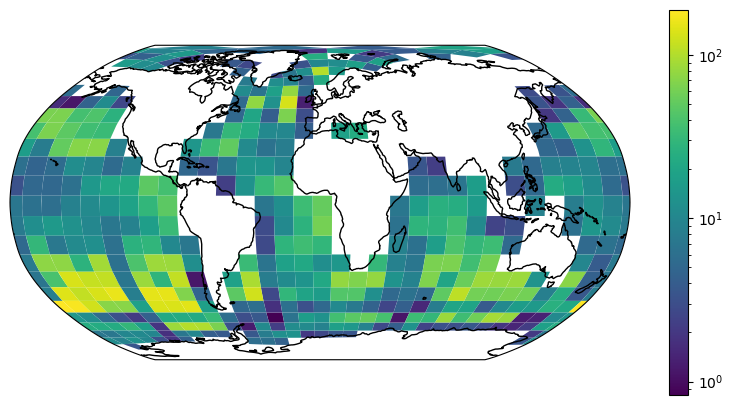

In [89]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=peakiness, cmap='viridis', edgecolors='none', norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
ax.add_collection(coll)
ax.autoscale_view()
plt.colorbar(coll)
plt.gcf().savefig('peakiness.png')

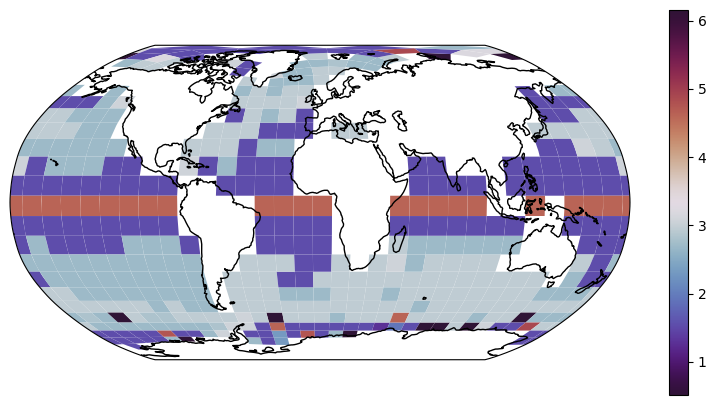

In [40]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()

from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)
# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=bins[max1], cmap='twilight_shifted', edgecolors='none', transform=ccrs.PlateCarree())
ax.add_collection(coll)
ax.autoscale_view()
plt.colorbar(coll)
plt.gcf().savefig('angle.png')

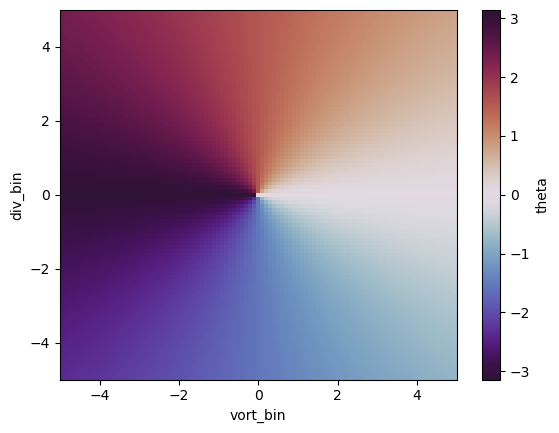

In [114]:
h1['theta'].plot(cmap='twilight_shifted')

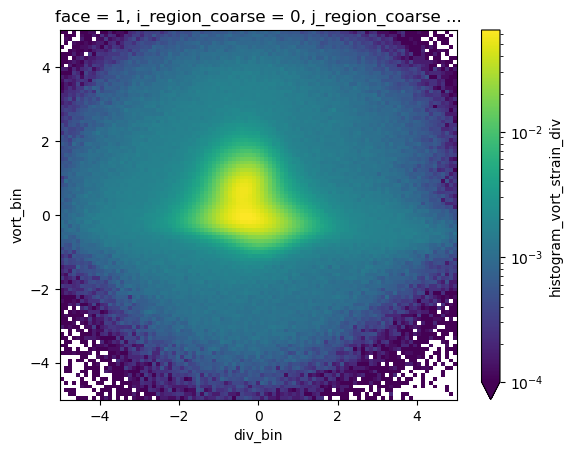

In [115]:
h1_gt_f.isel(region=27).plot(vmin=10**-4, norm=mpl.colors.LogNorm())#norm=mpl.colors.LogNorm()

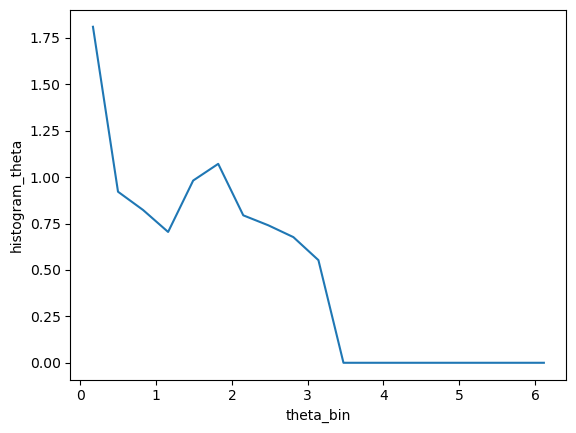

In [116]:
h_gt_f.isel(region=27).plot()

In [53]:
#mode(bins[max1])
vals,counts = np.unique(bins[max1], return_counts=True)

In [54]:
vals

array([0.51291309, 1.28228272, 1.53873926, 1.92342407, 2.30810889,
       2.6927937 , 2.82102197, 2.94925025, 3.07747852, 3.20570679,
       4.61621778, 4.74444605, 4.87267432, 6.15495704])

In [55]:
counts

array([  1,   1, 142,   1,   2, 105,   5, 128,  13,   3,  24,   2,   2,
         9])

In [56]:
bins

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

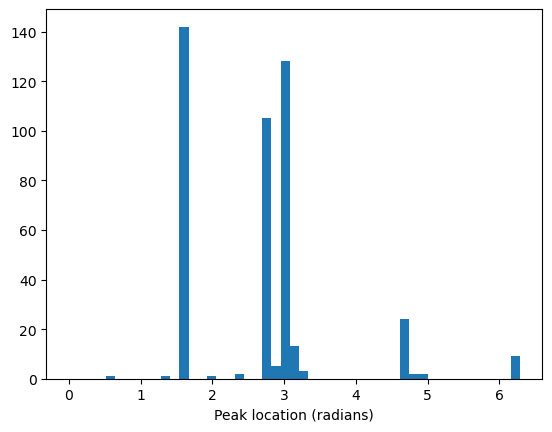

In [48]:
plt.hist(bins[max1],bins=bins)
plt.xlabel('Peak location (radians)')
plt.gcf().savefig('angle_hist.png')

ValueError: not enough values to unpack (expected 2, got 1)

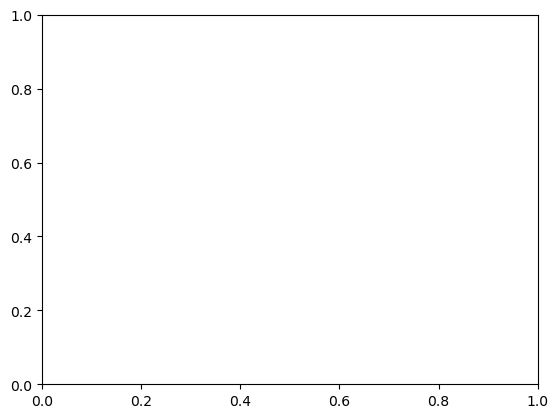

In [21]:
plt.pcolor(hist_ds.vertices_longitude.isel(vertices=0), hist_ds.vertices_latitude.isel(vertices=0), peakiness)

In [67]:
cells_above_f = h_gt_f.sum('theta_bin')

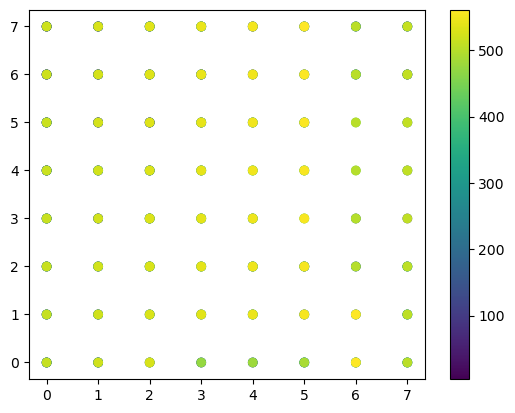

In [18]:
cs = plt.scatter(x=h.i_region_coarse, y=h.j_region_coarse, c=h.region_num)
plt.colorbar(cs)

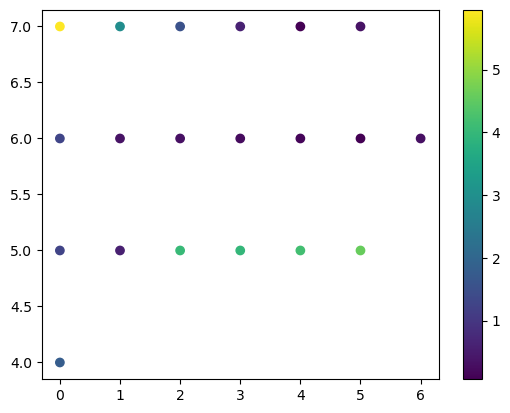

In [68]:
cs = plt.scatter(x=h.i_region_coarse, y=h.j_region_coarse, c=cells_above_f)
plt.colorbar(cs)

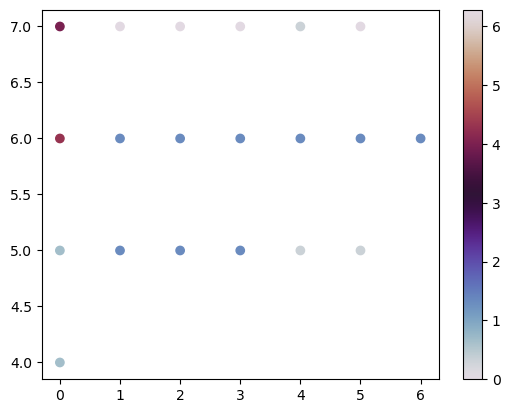

In [63]:
cs = plt.scatter(x=h.i_region_coarse, y=h.j_region_coarse, c=bins[max1], vmax=2*np.pi, vmin=0, cmap='twilight')
plt.colorbar(cs)

In [64]:
hist_ds

<xarray.Dataset> Size: 62GB
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 4kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 296B 2011-09-17T22:30:00...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 62GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [21]:
hist_ds.sel(region=130).vertices_latitude.values

array([-57.001026, -57.001026, -50.690105, -50.690105], dtype=float32)

In [27]:
h1.strain_bin

<xarray.DataArray 'strain_bin' (strain_bin: 49)> Size: 392B
array([0.05102 , 0.153061, 0.255102, 0.357143, 0.459184, 0.561224, 0.663265,
       0.765306, 0.867347, 0.969388, 1.071429, 1.173469, 1.27551 , 1.377551,
       1.479592, 1.581633, 1.683673, 1.785714, 1.887755, 1.989796, 2.091837,
       2.193878, 2.295918, 2.397959, 2.5     , 2.602041, 2.704082, 2.806122,
       2.908163, 3.010204, 3.112245, 3.214286, 3.316327, 3.418367, 3.520408,
       3.622449, 3.72449 , 3.826531, 3.928571, 4.030612, 4.132653, 4.234694,
       4.336735, 4.438776, 4.540816, 4.642857, 4.744898, 4.846939, 4.94898 ])
Coordinates:
    face             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    i_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    j_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    region_num       int64 8B 489
  * strain_bin       (strain_bin) float64 392B 0.05102 0.1531 ... 4.847 4.949

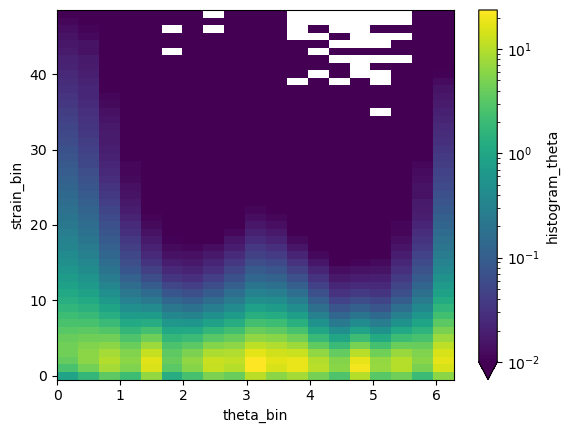

In [24]:
bins = np.linspace(0, 2*np.pi, 20)
weights=h1.fillna(0)
histogram(h1['theta'], bins=bins,weights=weights, dim=['div_bin','vort_bin']).plot(norm=colors.LogNorm(), vmin=1e-2)

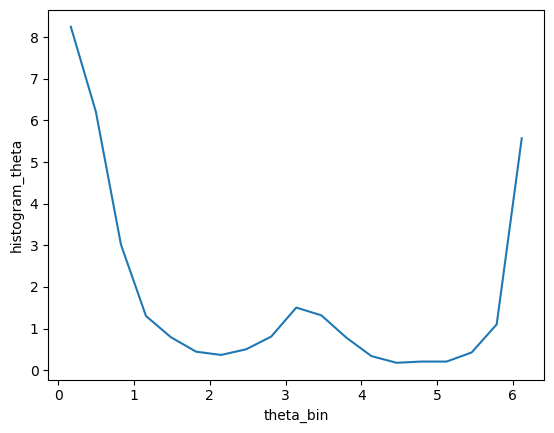

In [32]:
#histogram(h1['theta'], bins=bins,weights=weights, dim=['div_bin','vort_bin']).isel(strain_bin=slice(0,10)).sum('strain_bin').plot()
h_gt_f = histogram(h1['theta'], bins=bins,weights=weights, dim=['div_bin','vort_bin']).isel(strain_bin=slice(10,50)).sum('strain_bin')
#h_gt_f.plot()

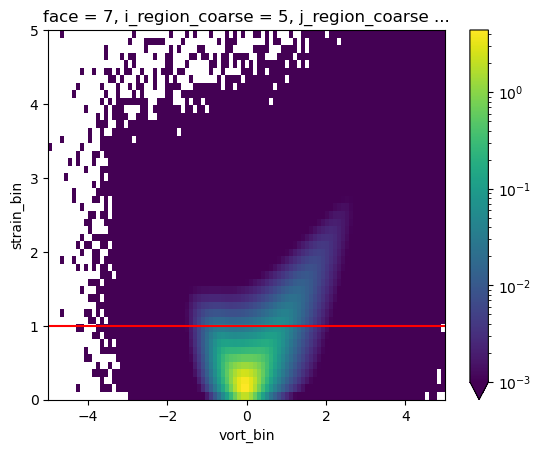

In [85]:
h.isel(region=230).pdf.marginalize('div_bin').mean('time').plot(x='vort_bin',vmin=0.001, norm=mpl.colors.LogNorm())
plt.axhline(1,c = 'r')
plt.gcf().savefig('plan.png')

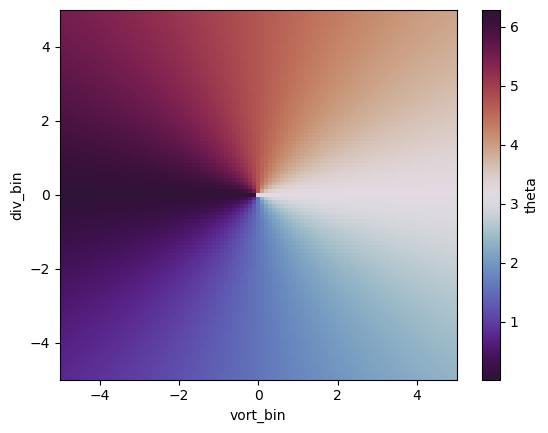

In [62]:
h1['theta'].plot(cmap = 'twilight_shifted')
plt.gcf().savefig('angle_key.png')

## Expectation values

In [70]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [71]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

## Latitude-dependent mean

We want to find the mean of all histograms, but defining the mean in such a way that it varies with latitude but not longitude, i.e. not across all regions.

In [13]:
hist_ds

<xarray.Dataset> Size: 62GB
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 4kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 296B 2011-09-17T22:30:00...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 62GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [14]:
# find the latitude of the centrepoint of each region polygon
lat = hist_ds['vertices_latitude'].mean(dim='vertices').rename('center_latitude')
lat

<xarray.DataArray 'center_latitude' (region: 438)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(438,), dtype=float32, chunksize=(438,), chunktype=numpy.ndarray>
Coordinates:
    face             (region) int64 4kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse  (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse  (region) int64 4kB dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num       (region) int64 4kB 4 5 6 7 13 14 ... 791 792 793 798 799
Dimensions without coordinates: region

In [15]:
hist_ds.coords['lat'] = lat.load()
hist_ds

<xarray.Dataset> Size: 62GB
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 4kB 0 0 0 0 0 0 ... 12 12 12 12 12
    i_region_coarse            (region) int64 4kB 0 0 0 0 1 1 1 ... 2 2 3 3 3 3
    j_region_coarse            (region) int64 4kB 4 5 6 7 5 6 7 ... 6 7 0 1 6 7
  * region_num                 (region) int64 4kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 296B 2011-09-17T22:30:00...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
    lat                        (region) float32 2kB -73.97 -69.45 ... -73.86
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 62GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [16]:
lat_bin_edges = np.arange(start=-90, stop=91, step=10)
lat_bin_edges

array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,
        40,  50,  60,  70,  80,  90])

In [17]:
h_vs_lat = hist_ds['histogram_vort_strain_div'].groupby_bins('lat', lat_bin_edges).mean(dim='region').isel(time=0)
h_vs_lat

<xarray.DataArray 'histogram_vort_strain_div' (lat_bins: 18, vort_bin: 99,
                                               strain_bin: 49, div_bin: 99)> Size: 69MB
dask.array<getitem, shape=(18, 99, 49, 99), dtype=float64, chunksize=(1, 99, 49, 99), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
    time        datetime64[ns] 8B 2011-09-17T22:30:00
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * lat_bins    (lat_bins) object 144B (-90, -80] (-80, -70] ... (80, 90]

In [18]:
h_vs_lat.pdf.expectation(1).load()

<xarray.DataArray (lat_bins: 18)> Size: 144B
array([0.        , 1.0017813 , 1.00757282, 1.01151839, 1.0047085 ,
       1.00905651, 1.01497235, 1.02412999, 1.01651403, 1.01582547,
       1.01898524, 1.00710788, 1.01646905, 1.02777282, 1.01558758,
       1.01121717, 1.00704632, 1.01325677])
Coordinates:
    time        datetime64[ns] 8B 2011-09-17T22:30:00
  * lat_bins    (lat_bins) object 144B (-90, -80] (-80, -70] ... (80, 90]
    vort_bin    float64 8B -4.848
    strain_bin  float64 8B 0.1531
    div_bin     float64 8B -4.848

In [72]:
h_vort_strain_vs_lat = h_vs_lat.pdf.marginalize('div_bin')
h_vort_strain_vs_lat

NameError: name 'h_vs_lat' is not defined

In [20]:
h_vort_strain_vs_lat.pdf.expectation(1, dims=['vort_bin', 'strain_bin']).load()

<xarray.DataArray (lat_bins: 18)> Size: 144B
array([0.        , 1.0017813 , 1.00757282, 1.01151839, 1.0047085 ,
       1.00905651, 1.01497235, 1.02412999, 1.01651403, 1.01582547,
       1.01898524, 1.00710788, 1.01646905, 1.02777282, 1.01558758,
       1.01121717, 1.00704632, 1.01325677])
Coordinates:
    time        datetime64[ns] 8B 2011-09-17T22:30:00
  * lat_bins    (lat_bins) object 144B (-90, -80] (-80, -70] ... (80, 90]
    div_bin     float64 8B -4.848
    vort_bin    float64 8B -4.848
    strain_bin  float64 8B 0.1531

In [21]:
h_vort_strain_vs_lat.sum(dim=['vort_bin', 'strain_bin']).load()

<xarray.DataArray (lat_bins: 18)> Size: 144B
array([ 0.        , 97.19282192, 97.75471455, 98.13751391, 97.47681873,
       97.89866217, 98.47261784, 99.36109145, 98.62219071, 98.5553869 ,
       98.86194824, 97.70960648, 98.61782689, 99.71451862, 98.53230729,
       98.10829024, 97.70363414, 98.3061716 ])
Coordinates:
    time      datetime64[ns] 8B 2011-09-17T22:30:00
  * lat_bins  (lat_bins) object 144B (-90, -80] (-80, -70] ... (70, 80] (80, 90]
    div_bin   float64 8B -4.848

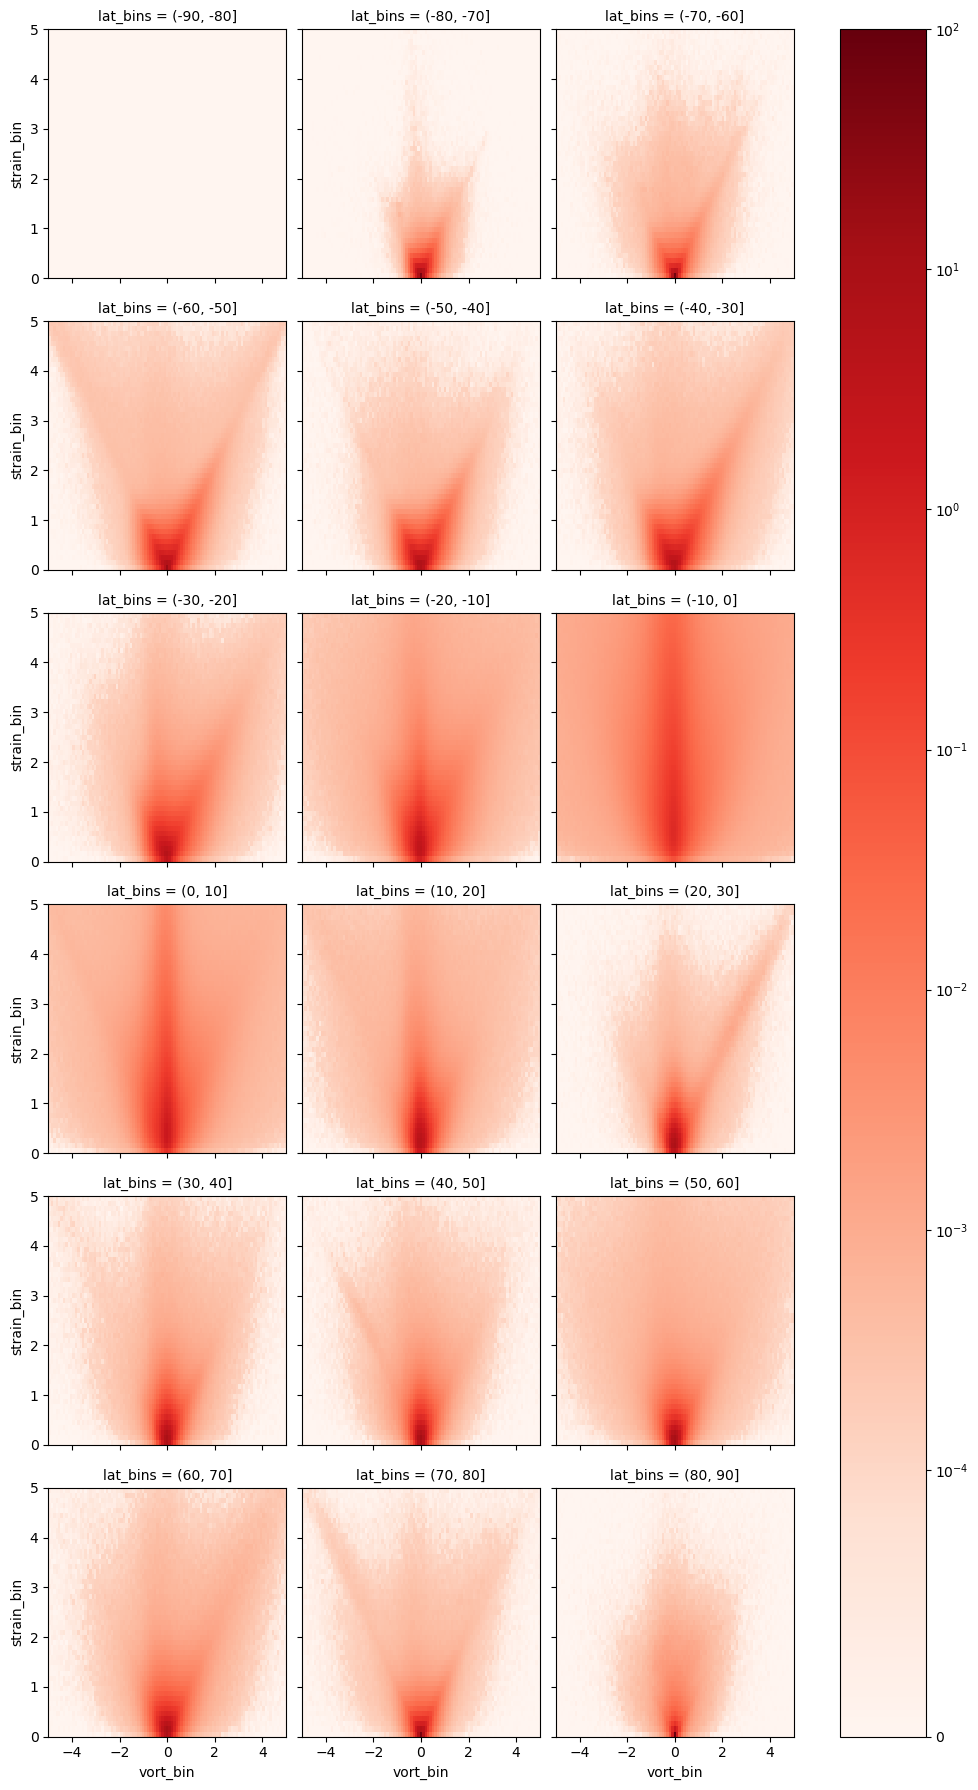

In [22]:
h_vort_strain_vs_lat.plot(x='vort_bin', col='lat_bins', col_wrap=3, vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')